In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
s = 'https://archive.ics.uci.edu/ml/'\
    'machine-learning-databases/iris/iris.data'
print("From url:", s)
df_iris = pd.read_csv(s, header=None, encoding='utf-8')
df_iris.tail()


From url: https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data


,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


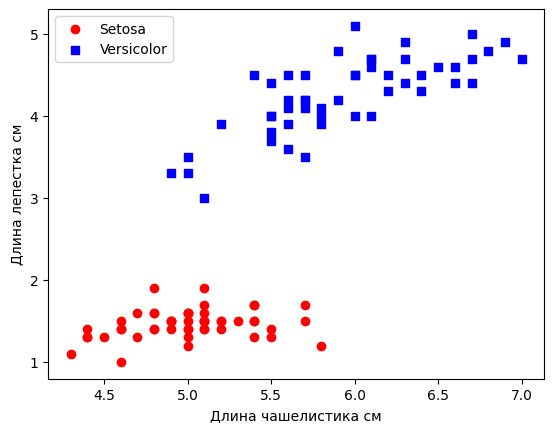

In [4]:
y = df_iris.iloc[0:100, 4].values
y = np.where(y == "Iris-setosa", 0, 1)
X = df_iris.iloc[0:100, [0, 2]].values
plt.scatter(X[:50, 0], X[:50, 1], c='red', marker='o', label='Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], c='blue', marker='s', label='Versicolor')
plt.xlabel("Длина чашелистика см")
plt.ylabel("Длина лепестка см")
plt.legend(loc='upper left')
plt.show()

In [5]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:, [2, 3]]
y = iris.target
print(np.unique(y))

[0 1 2]


In [6]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(X[y == cl, 0], 
                    X[y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=f'Class {cl}',
                    edgecolors='black')
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1], c='none', edgecolor='black', alpha=1.0, linewidths=1, marker='o', s=100, label='Test set')


In [7]:
class AdalineGD:

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        return X
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

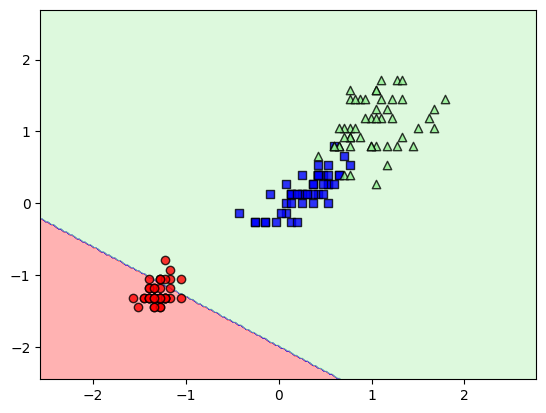

In [8]:
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
ada_gd = AdalineGD(0.5, 20)
ada_gd.fit(X_std, y)
plot_decision_regions(X_std, y, ada_gd)

# Классификаторы из scikit-learn

In [9]:
class LogisticRegressionGD:

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = float(0.)
        self.losses_ = []

        for _ in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = y - output
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (-y.dot(np.log(output)) - (1 - y).dot(np.log(1 - output))) / X.shape[0]
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [10]:
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

scaler = StandardScaler()
scaler.fit(X_train_iris)
X_train_std = scaler.transform(X_train_iris)
X_test_std = scaler.transform(X_test_iris)

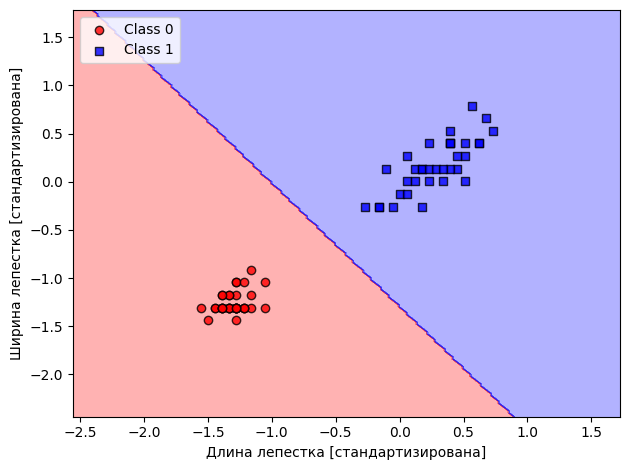

In [11]:
X_train_01_subset = X_train_std[(y_train_iris == 0) | (y_train_iris == 1)]
y_train_01_subset = y_train_iris[(y_train_iris == 0) | (y_train_iris == 1)]
lrgd = LogisticRegressionGD(eta=0.3, n_iter=1000, random_state=1)
lrgd.fit(X_train_01_subset, y_train_01_subset)
plot_decision_regions(X_train_01_subset, y_train_01_subset, lrgd)
plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

c:\Users\Глеб\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


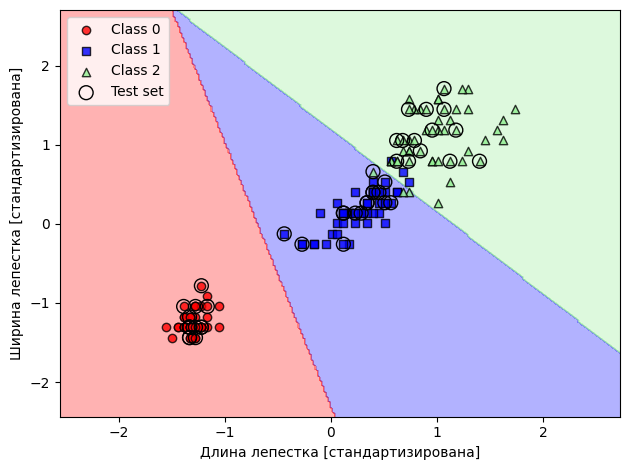

In [12]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, solver='lbfgs', multi_class='ovr')
lr.fit(X_train_std, y_train_iris)
plot_decision_regions(np.vstack((X_train_std, X_test_std)), np.hstack((y_train_iris, y_test_iris)), lr, range(105, 150))

plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

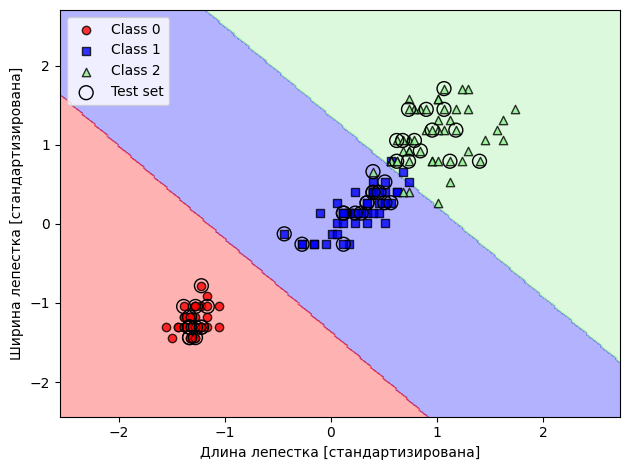

In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train_iris)
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train_iris, y_test_iris))
plot_decision_regions(X_combined_std, y_combined, svm, range(105, 150))

plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

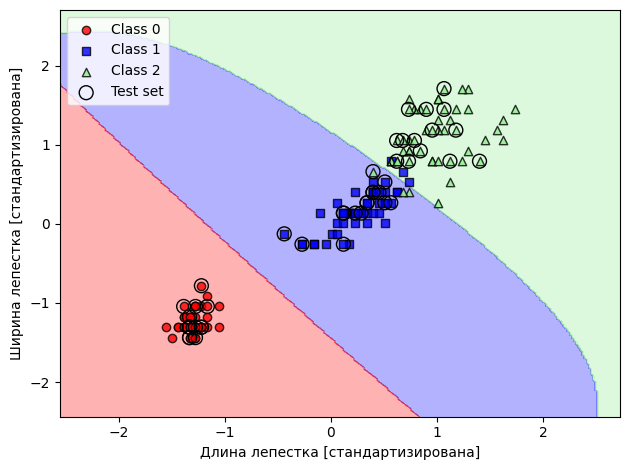

In [14]:
svmk = SVC(kernel='rbf', random_state=1, gamma=0.2, C=1.0)
svmk.fit(X_train_std, y_train_iris)
plot_decision_regions(X_combined_std, y_combined, classifier=svmk, test_idx=range(105, 150))

plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

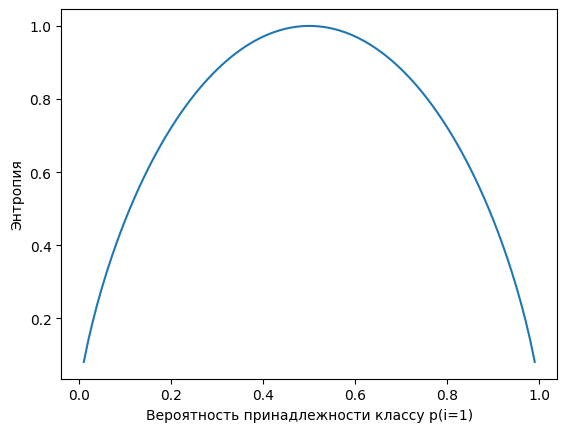

In [15]:
def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))

x = np.arange(0.0, 1.0, 0.01)
ent = [entropy(p) if p != 0 else None for p in x]
plt.ylabel('Энтропия')
plt.xlabel('Вероятность принадлежности классу p(i=1)')
plt.plot(x, ent)
plt.show()

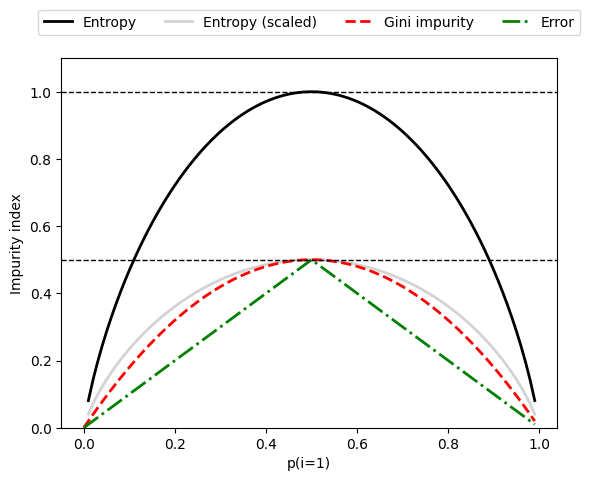

In [16]:
def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))

def error(p):
    return 1 - np.max([p, 1 - p])

sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]
fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err],
                          ['Entropy', 'Entropy (scaled)',
                           'Gini impurity',
                           'Error'], 
                           ['-', '-', '--', '-.'],
                           ['black', 'lightgrey', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity index')
plt.show()

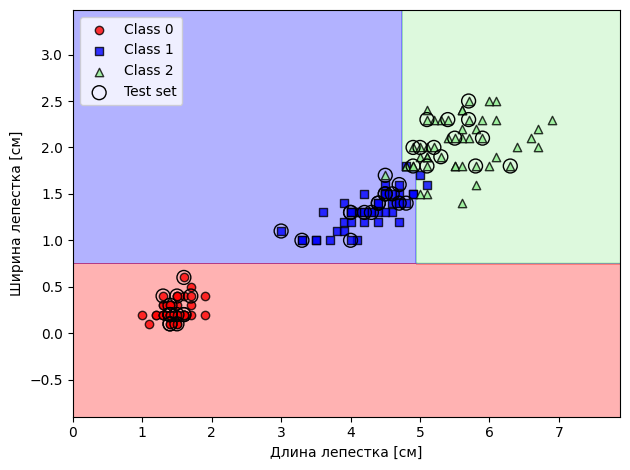

In [17]:
from sklearn.tree import DecisionTreeClassifier


tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree_model.fit(X_train_iris, y_train_iris)
X_combined = np.vstack((X_train_iris, X_test_iris))
plot_decision_regions(X_combined, y_combined, classifier=tree_model, test_idx=range(105, 150))

plt.xlabel("Длина лепестка [см]")
plt.ylabel("Ширина лепестка [см]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

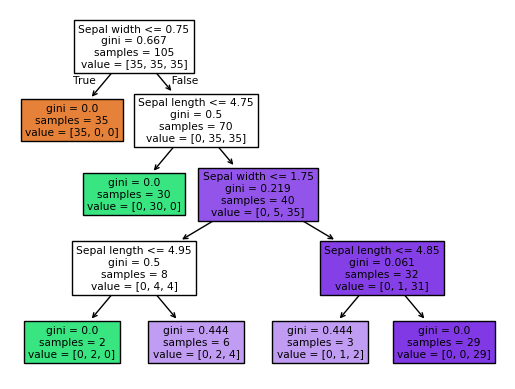

In [18]:
from sklearn import tree

feature_names = ['Sepal length', 'Sepal width',
                 'Petal length', 'Petal width']
tree.plot_tree(tree_model, feature_names=feature_names, filled=True)
plt.show()

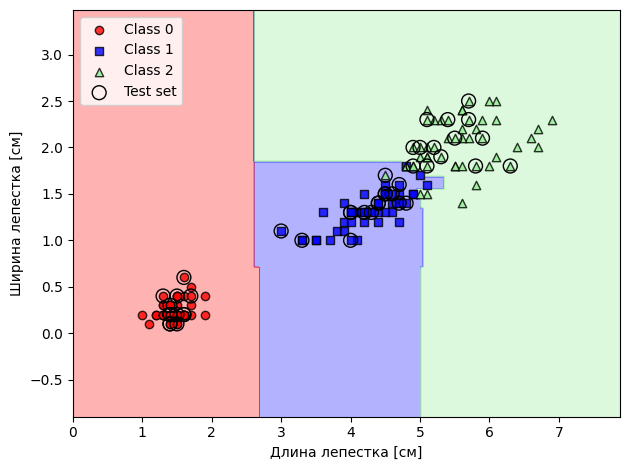

In [19]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=25,
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train_iris, y_train_iris)
plot_decision_regions(X_combined, y_combined,
                      classifier=forest, test_idx=range(105, 150))
plt.xlabel("Длина лепестка [см]")
plt.ylabel("Ширина лепестка [см]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

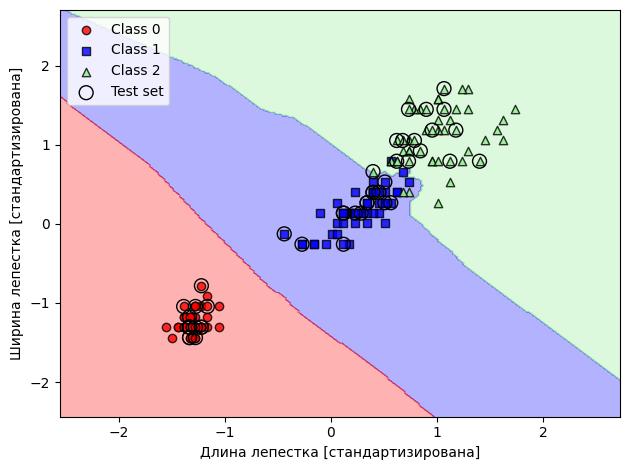

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2,
                           metric='minkowski')
knn.fit(X_train_std, y_train_iris)
plot_decision_regions(X_combined_std, y_combined,
                      classifier=knn, test_idx=range(105, 150))
plt.xlabel("Длина лепестка [стандартизирована]")
plt.ylabel("Ширина лепестка [стандартизирована]")
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Предобработка данных для качественных обучающих наборов
## Выявление пустых данных

In [21]:
from io import StringIO
csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''
df = pd.read_csv(StringIO(csv_data))

In [22]:
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

## Удаление пустых значений

In [23]:
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [24]:
df.dropna(subset=['C']) # Удаляет строки, в которых NaN содержится только в заданных столбцах

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


In [25]:
df.fillna(df.mean())

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,7.5,8.0
2,10.0,11.0,12.0,6.0


## Работа с категориальными признаками

In [26]:
df1 = pd.DataFrame([
            ['green', 'M', 10.1, 'class2'],
            ['red', 'L', 13.5, 'class1'],
            ['blue', 'XL', 15.3, 'class2']])
df1.columns = ['color', 'size', 'price', 'classlabel']
df1

,color,size,price,classlabel
0,green,M,10.1,class2
1,red,L,13.5,class1
2,blue,XL,15.3,class2


In [27]:
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}
df1['size'] = df1['size'].map(size_mapping)
df1

,color,size,price,classlabel
0,green,1,10.1,class2
1,red,2,13.5,class1
2,blue,3,15.3,class2


In [28]:
class_mapping = {label: idx for idx, label in 
                enumerate(np.unique(df1['classlabel']))}
df1['classlabel'] = df1['classlabel'].map(class_mapping)
df1 # Ручной LabelEncoder()

,color,size,price,classlabel
0,green,1,10.1,1
1,red,2,13.5,0
2,blue,3,15.3,1


In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df1['classlabel'].values)
y

array([1, 0, 1])

In [30]:
from sklearn.preprocessing import OneHotEncoder
X = df1[['color', 'size', 'price']].values
ohe = OneHotEncoder() # Если передать в аргументы drop='first', category='auto', то ничего не потеряем
ohe.fit_transform(X[:, 0].reshape(-1, 1)).toarray()

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [31]:
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer([
    ('onehot', OneHotEncoder(), [0]),
    ('nothing', 'passthrough', [1, 2])
])
ct.fit_transform(X).astype(float)

array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

In [32]:
pd.get_dummies(df1[['color', 'size', 'price']])

,size,price,color_blue,color_green,color_red
0,1,10.1,False,True,False
1,2,13.5,False,False,True
2,3,15.3,True,False,False


## Раздзеление набора данных

In [33]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'wine/wine.data', header=None)

In [34]:
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium',
                   'Total phenols', 'Flavanoids',
                   'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [35]:
from sklearn.model_selection import train_test_split
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y) # Для огромных наборов данных уместно соотношение 90:10 (>= 100тыс. записей)

### Многие алгоритмы хотят масштабирования, не хотят только случайные леса
Есть *нормализация* - числа в диапазон [0, 1].  
Есть *стандартизация* - центрируем столбцы данных по среднему значению 0 со стандартным отклонением 1.

Используются  
*MinMaxScaler()* - для нормализации  
*StandartScaler()* - стандартизации  
*RobustScaler()* - поможет при малом наборе данных и сильных выбросах, если алгоритм склонен к переобучению

In [36]:
from sklearn.preprocessing import StandardScaler
ssc = StandardScaler()
X_train_std = ssc.fit_transform(X_train)
X_test_std = ssc.fit_transform(X_test)

### Способы борьбы с переобучением
- собрать больше обучающих данных (редко и почти анрил)
- регуляризация
- взять более простую модель
- уменьшть размерность данных

In [37]:
lr = LogisticRegression(penalty='l1',
                        C=1.0,
                        solver='liblinear',
                        multi_class='ovr')
lr.fit(X_train_std, y_train)
print(f'Точность при обучении: {lr.score(X_train_std, y_train)}')
print(f'Точность при тестировании: {lr.score(X_test_std, y_test)}')

Точность при обучении: 1.0
Точность при тестировании: 1.0


c:\Users\Глеб\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [38]:
lr.coef_

array([[ 1.24540622,  0.18064737,  0.74624087, -1.1635365 ,  0.        ,
         0.        ,  1.15968274,  0.        ,  0.        ,  0.        ,
         0.        ,  0.55655518,  2.50936889],
       [-1.53871167, -0.38629078, -0.99561033,  0.36445077, -0.05920376,
         0.        ,  0.66720992,  0.        ,  0.        , -1.93238897,
         1.23637626,  0.        , -2.23213501],
       [ 0.13504262,  0.16973087,  0.35759167,  0.        ,  0.        ,
         0.        , -2.43389577,  0.        ,  0.        ,  1.5623517 ,
        -0.81674195, -0.49749483,  0.        ]])

### Измерить важность признака можно с помощью алгоритма случайного леса

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_labels = df_wine.columns[1:]
forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print(f'{f}) {forest_labels[indices[f]]}      {round(importances[f], 6)}')

0) Proline      0.118529
1) Flavanoids      0.025648
2) Color intensity      0.013279
3) OD280/OD315 of diluted wines      0.022366
4) Alcohol      0.031357
5) Hue      0.050872
6) Total phenols      0.174751
7) Magnesium      0.013354
8) Malic acid      0.02557
9) Proanthocyanins      0.14392
10) Alcalinity of ash      0.058739
11) Nonflavanoid phenols      0.136162
12) Ash      0.185453


In [40]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print(f'Количество признаков, соответствующих пороговому критерию {X_selected.shape[1]}')

Количество признаков, соответствующих пороговому критерию 5


## Сжатие данных для уменьшения размерности

c:\Users\Глеб\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


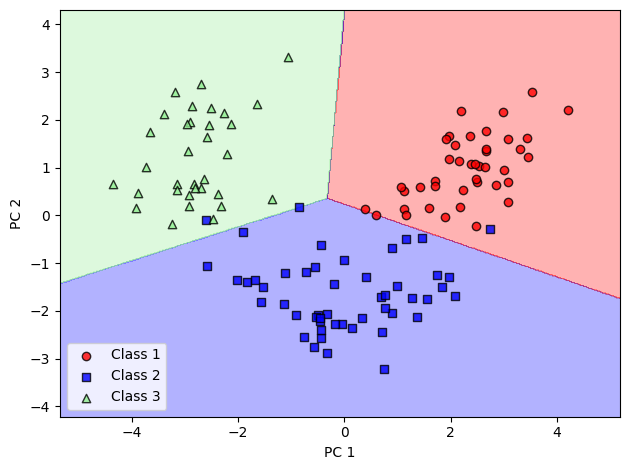

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2) # Обучение без учителя, данные должны быть стандартизированы
lr = LogisticRegression(multi_class='ovr', random_state=1, solver='lbfgs')
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
lr.fit(X_train_pca, y_train)
plot_decision_regions(X_train_pca, y_train, lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

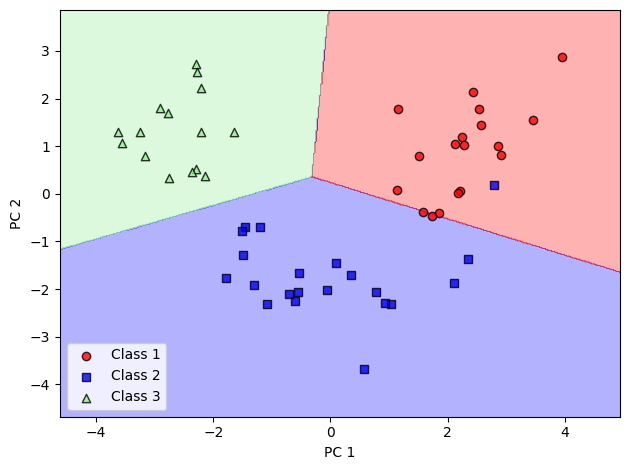

In [42]:
plot_decision_regions(X_test_pca, y_test, lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

c:\Users\Глеб\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


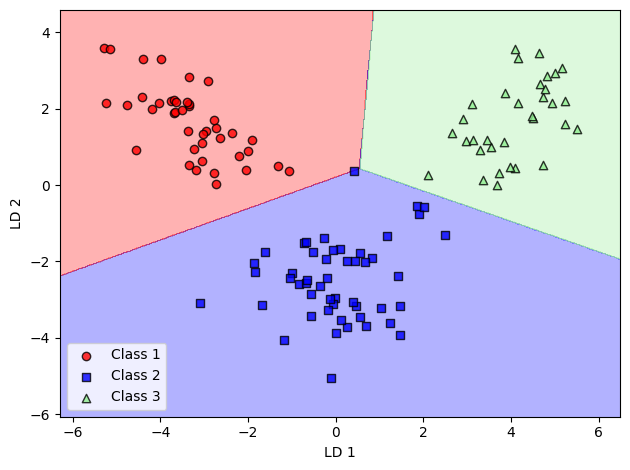

In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2) # С учителем, тоже линейное преобразование
X_train_lda = lda.fit_transform(X_train_std, y_train)
lr.fit(X_train_lda, y_train)
plot_decision_regions(X_train_lda, y_train, lr)
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

In [44]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import matplotlib.patheffects as PathEffects
digits = load_digits()
y_digits = digits.target
X_digits = digits.data
tsne = TSNE(n_components=2, init='pca', random_state=123)
X_digits_tsne = tsne.fit_transform(X_digits)

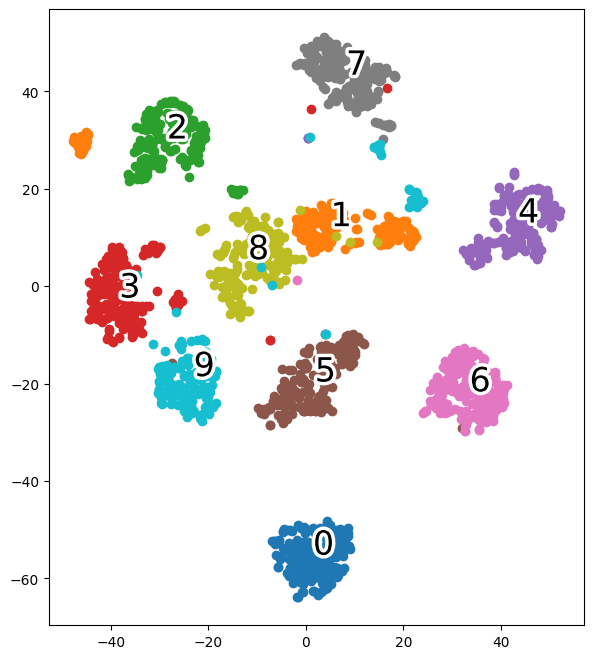

In [45]:
def plot_projection(x, colors):
    fig = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    for i in range(10):
        plt.scatter(x[colors == i, 0],
                    x[colors == i, 1])
    for i in range(10):
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground='w'),
            PathEffects.Normal()])

plot_projection(X_digits_tsne, y_digits)
plt.show()

## Методы оценки моделей и настройки гиперпараметров

In [46]:
df_cancer = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/'
                      'breast-cancer-wisconsin/wdbc.data', header=None)
X = df_cancer.loc[:, 2:].values
y = df_cancer.loc[:, 1].values
y = le.fit_transform(y)
le.classes_

array(['B', 'M'], dtype=object)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

In [48]:
from sklearn.pipeline import make_pipeline
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression())
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
test_acc = pipe_lr.score(X_test, y_test)
print(f'Точность на тестовых данных {test_acc:.3f}')

Точность на тестовых данных 0.956


In [49]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print(f'Выборка: {k + 1:02d}, '
          f'Распр. кл.: {np.bincount(y_train[train])}, '
          f'Точность: {score:.3f}')
mean_acc = np.mean(scores)
std_acc = np.std(scores)
print(f'Точность по кросс валидации: {mean_acc:.3f} +/- {std_acc:.3f}')

Выборка: 01, Распр. кл.: [256 153], Точность: 0.935
Выборка: 02, Распр. кл.: [256 153], Точность: 0.935
Выборка: 03, Распр. кл.: [256 153], Точность: 0.957
Выборка: 04, Распр. кл.: [256 153], Точность: 0.957
Выборка: 05, Распр. кл.: [256 153], Точность: 0.935
Выборка: 06, Распр. кл.: [257 153], Точность: 0.956
Выборка: 07, Распр. кл.: [257 153], Точность: 0.978
Выборка: 08, Распр. кл.: [257 153], Точность: 0.933
Выборка: 09, Распр. кл.: [257 153], Точность: 0.956
Выборка: 10, Распр. кл.: [257 153], Точность: 0.956
Точность по кросс валидации: 0.950 +/- 0.014


In [50]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print(f"Точность по CV: {np.mean(scores)}")

Точность по CV: 0.9495169082125603


### Кривые валидации

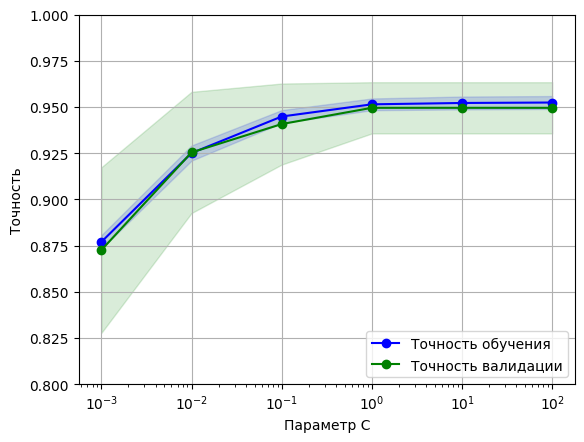

In [51]:
from sklearn.model_selection import validation_curve


param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='logisticregression__C',
    param_range=param_range,
    cv=10
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue',
         marker='o', label='Точность обучения')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='green',
         marker='o', label='Точность валидации')
plt.fill_between(param_range, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Параметр C')
plt.ylabel('Точность')
plt.ylim([0.8,  1.0])
plt.show()

### Поиск по сетке (медленно но точно)

In [52]:
from sklearn.model_selection import GridSearchCV


pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range,
               'svc__kernel': ['linear']},
              {'svc__C': param_range,
               'svc__gamma': param_range, # только для ядерных моделей
               'svc__kernel': ['rbf']}]
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=10,
                  refit=True,
                  n_jobs=-1)
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [53]:
clf = gs.best_estimator_
# clf.fit(X_train, y_train) - есть refit = True
print(clf.score(X_test, y_test))

0.9736842105263158


In [54]:
from scipy import stats
from sklearn.model_selection import RandomizedSearchCV
rs_param_range = stats.loguniform(0.0001, 1000.0)
param_grid = [{'svc__C': rs_param_range,
               'svc__kernel': ['linear']},
              {'svc__C': rs_param_range,
               'svc__gamma': param_range, # только для ядерных моделей
               'svc__kernel': ['rbf']}]
rs = RandomizedSearchCV(estimator=pipe_svc,
                        param_distributions=param_grid,
                        scoring='accuracy',
                        refit=True,
                        n_iter=20,
                        cv=10,
                        random_state=1,
                        n_jobs=-1)
rs.fit(X_train, y_train)
print(rs.best_score_)
print(rs.best_params_)

0.9846859903381642
{'svc__C': np.float64(113.53813701628422), 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [55]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
hs = HalvingRandomSearchCV(pipe_svc,
                           param_distributions=param_grid,
                           n_candidates='exhaust',
                           resource='n_samples',
                           factor=1.5,
                           random_state=1,
                           n_jobs=-1)
hs = hs.fit(X_train, y_train)
print(hs.best_score_)
print(hs.best_params_)

0.9617647058823529
{'svc__C': np.float64(113.53813701628422), 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


In [56]:
from sklearn.metrics import make_scorer, f1_score


c_gamma_range = [0.01, 0.1, 1.0, 10.0]
param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range, # только для ядерных моделей
               'svc__kernel': ['rbf']}]

scorer = make_scorer(f1_score, pos_label=0)
gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


### Борьба с дисбалансом классов - использование различных метрик, параметр class_weight='balanced'

## Ансамблевое обучение

In [57]:
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error ** k * (1 - error) ** (n_classifier - k) for k in range(k_start, n_classifier + 1)]
    return sum(probs)

ensemble_error(n_classifier=11, error=0.25)

np.float64(0.03432750701904297)

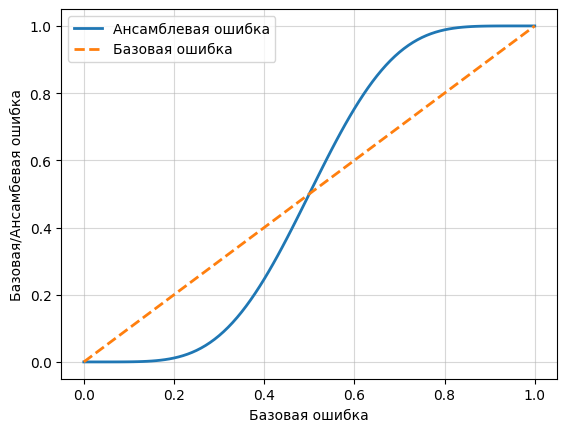

In [58]:
error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_errors, label='Ансамблевая ошибка', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Базовая ошибка', linewidth=2)
plt.xlabel('Базовая ошибка')
plt.ylabel('Базовая/Ансамбевая ошибка')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.show()

In [59]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.pipeline import _name_estimators
import operator


class MajorityVoteClassifier(ClassifierMixin, BaseEstimator):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {
            key: value for key, value in _name_estimators(classifiers)
        }
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote должен быть 'probability' "
                             f"или 'classlabel'"
                             f"; got (vote={self.vote})")
        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f"Количество классификаторов и весов должно совпадать; имеются {len(self.weights)} весов,"
                             f" {len(self.classifiers)} классификаторов")
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)

        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predicts = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predicts)
            maj_vote = self.labelenc_.inverse_transform(maj_vote)
            return maj_vote
        
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out


In [60]:
X_iris, y_iris = iris.data[50:, [1, 2]], iris.target[50:]
y_iris = le.fit_transform(y_iris)

In [61]:
X_train_iris1, X_test_iris1, y_train_iris1, y_test_iris1 = train_test_split(X_iris, y_iris, test_size=0.5, random_state=1, stratify=y_iris)

### Сравниваем классификаторы по отдельности и вместе

In [62]:
from sklearn.pipeline import Pipeline


clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)
clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])
clf_labels = ['Логистическая регрессия', 'Дерево решений', 'KNN']
print('10-кратная перекрестная проверка\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train_iris1,
                             y=y_train_iris1,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} [{label}]')

10-кратная перекрестная проверка

ROC AUC: 0.92 [Логистическая регрессия]
ROC AUC: 0.87 [Дерево решений]
ROC AUC: 0.85 [KNN]


In [63]:
mv_clf = MajorityVoteClassifier(classifiers=[clf1, clf2, clf3])
clf_labels += ['Мажоритарное голосование']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train_iris1,
                             y=y_train_iris1,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} [{label}]')

ROC AUC: 0.92 [Логистическая регрессия]
ROC AUC: 0.87 [Дерево решений]
ROC AUC: 0.85 [KNN]
ROC AUC: 0.97 [Мажоритарное голосование]


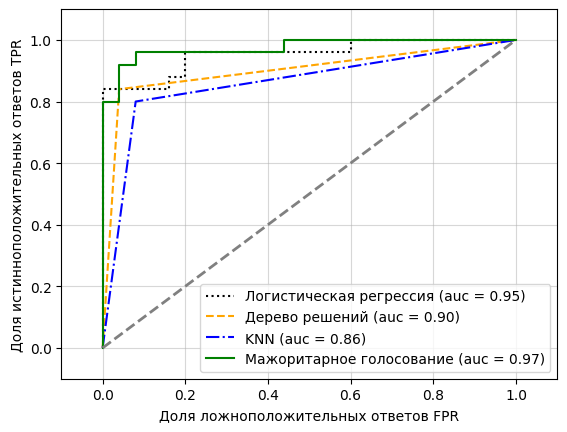

In [64]:
from sklearn.metrics import roc_curve, auc


colors = ['black', 'orange', 'blue', 'green']
linestyle = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyle):
    y_pred = clf.fit(X_train_iris1, y_train_iris1).predict_proba(X_test_iris1)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_iris1, y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('Доля ложноположительных ответов FPR')
plt.ylabel('Доля истинноположительных ответов TPR')
plt.show()

Бэггинг - бутстрап + аггрегация - нужно для буста деревьев решений, мы берем выборку с возвращением и обучаем отдельное дерево параллельно

In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


xgb = XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1)
gbm = xgb.fit(X_train_iris1, y_train_iris1)
y_train_iris_pred = gbm.predict(X_train_iris1)
y_test_iris_pred = gbm.predict(X_test_iris1)
train_score = accuracy_score(y_train_iris1, y_train_iris_pred)
test_score = accuracy_score(y_test_iris1, y_test_iris_pred)
print(train_score)
print(test_score)

0.94
0.9


## Смысловой анализ текста (чутка NLP)

In [66]:
import tarfile
with tarfile.open('aclImdb_v1.tar.gz', 'r:gz') as tar:
    tar.extractall()

In [68]:
import pyprind
import os
import sys


BASEPATH = 'aclImdb'
labels = {'pos': 1, 'neg': 0}
pbar =  pyprind.ProgBar(50000, stream=sys.stdout)
data = []
for s in ('test', 'train'):
    for i in ('pos', 'neg'):
        path = os.path.join(BASEPATH, s, i)
        for fil in sorted(os.listdir(path)):
            with open(os.path.join(path, fil), 'r', encoding='utf-8') as file_in:
                txt = file_in.read()
            data.append([txt, labels[i]])
            pbar.update()
df_nlp = pd.DataFrame(data, columns=['review', 'sentiment'])

In [69]:
np.random.seed(0)
df_nlp = df_nlp.reindex(np.random.permutation(df_nlp.index))
df_nlp.to_csv('movie_data.csv', index=False, encoding='utf-8')

In [70]:
df_nlp = pd.read_csv('movie_data.csv', encoding='utf-8')
df_nlp.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [76]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import re


def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emotions = re.findall('(?::|;|=) (?:-)?(?:\)|\(|D|P)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emotions).replace('-', ''))
    return text

df_nlp = df_nlp['review'].apply(preprocessor)
count = CountVectorizer()
tfidf = TfidfTransformer(use_idf=True, norm='l2', smooth_idf=True)


In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
porter = PorterStemmer()
stopwords = stopwords.words('english')


def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]